In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

def load_and_preprocess_images(folder, target_size=(256, 256), color_mode='rgb'):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        if color_mode == 'grayscale':
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_COLOR)
        if img is not None:
            resized_img = cv2.resize(img, target_size)
            if color_mode == 'grayscale':
                resized_img = np.expand_dims(resized_img, axis=-1)
            images.append(resized_img)
            filenames.append(filename)
    return images, filenames

# Load and preprocess images (color) and labels (grayscale)
train_images, image_filenames = load_and_preprocess_images("C:/Users/srini/OneDrive - Amrita vishwa vidyapeetham/Desktop/training/images/", color_mode='rgb')
train_labels, label_filenames = load_and_preprocess_images("C:/Users/srini/OneDrive - Amrita vishwa vidyapeetham/Desktop/training/labels/", color_mode='grayscale')

# Ensure that images and labels are matched correctly
assert image_filenames == label_filenames, "Mismatch between image and label files"

# Convert lists to numpy arrays for easier manipulation
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Normalize pixel values
train_images = train_images / 255.0
train_labels = np.where(train_labels > 0, 1, 0).astype(np.float32)  # Binarize labels and convert to float32

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Data Augmentation
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

image_generator = image_datagen.flow(X_train, batch_size=16, seed=seed)
mask_generator = mask_datagen.flow(y_train, batch_size=16, seed=seed)

def combined_generator(image_gen, mask_gen):
    while True:
        image_batch = image_gen.__next__()
        mask_batch = mask_gen.__next__()
        yield image_batch, mask_batch

train_generator = combined_generator(image_generator, mask_generator)

def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), padding='same', activation='relu')(pool1)
    conv2 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), padding='same', activation='relu')(pool2)
    conv3 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Decoder
    up4 = concatenate([UpSampling2D(size=(2, 2))(conv3), conv2], axis=-1)
    conv4 = Conv2D(128, (3, 3), padding='same', activation='relu')(up4)
    conv4 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv4)

    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv1], axis=-1)
    conv5 = Conv2D(64, (3, 3), padding='same', activation='relu')(up5)
    conv5 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv5)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dice_coefficient])

    return model

# Create the model
model = unet()
model.summary()

# Set up early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model with early stopping and model checkpoint
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // 16,
                    validation_data=(X_val, y_val), 
                    epochs=100, 
                    verbose=1,
                    callbacks=[early_stopping, model_checkpoint])

# Check if early stopping was triggered
if len(history.history['val_loss']) < 100:
    print("Early stopping was triggered. Training stopped early.")
else:
    print("Training completed without early stopping.")

# Save the model
model.save("final_model.h5")
print("Final model saved as final_model.h5")



C:\Users\srini\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 256, 256,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 192)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_8[0][0]  

 Total params: 1,883,137 (7.18 MB)

 Trainable params: 1,883,137 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 17s/step - accuracy: 0.4112 - dice_coefficient: 0.4327 - loss: 0.6941 - val_accuracy: 0.4574 - val_dice_coefficient: 0.4911 - val_loss: 0.6848
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 16s/step - accuracy: 0.4548 - dice_coefficient: 0.4293 - loss: 0.6908 - val_accuracy: 0.5463 - val_dice_coefficient: 0.4581 - val_loss: 0.6984
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 10s/step - accuracy: 0.4847 - dice_coefficient: 0.4312 - loss: 0.6940 - val_accuracy: 0.8786 - val_dice_coefficient: 0.4836 - val_loss: 0.6798
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 29s 16s/step - accuracy: 0.7214 - dice_coefficient: 0.4597 - loss: 0.6783 - val_accuracy: 0.4603 - val_dice_coefficient: 0.5254 - val_loss: 0.6567
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 16s/step - accuracy: 0.5203 - dice_coefficient: 0.4279 - loss: 0.6869 - val_accuracy: 0.6198 - val_dice_coefficient: 0.4752 - val_loss: 0.6640
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 10s/step - accuracy: 0.6998 - dice_coef

Training completed without early stopping.
Final model saved as final_model.h5


In [3]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluate the model on the validation set
val_loss, val_accuracy, val_dice_coefficient = model.evaluate(X_val, y_val, verbose=0)

# Predict on validation set
y_val_pred = model.predict(X_val)

# Calculate IoU (Intersection over Union)
def calculate_iou(y_true, y_pred):
    intersection = np.sum(np.logical_and(y_true, y_pred))
    union = np.sum(np.logical_or(y_true, y_pred))
    return intersection / union

iou_scores = [calculate_iou(y_val[i], y_val_pred[i]) for i in range(len(y_val))]

# Calculate Dice Coefficient
dice_scores = [dice_coefficient(y_val[i], y_val_pred[i]) for i in range(len(y_val))]

# Calculate precision, recall, and F1-score
def calculate_precision_recall_f1(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(np.float32)
    precision = precision_score(y_true.flatten(), y_pred_binary.flatten(), average='binary')
    recall = recall_score(y_true.flatten(), y_pred_binary.flatten(), average='binary')
    f1 = f1_score(y_true.flatten(), y_pred_binary.flatten(), average='binary')
    return precision, recall, f1

precision_scores, recall_scores, f1_scores = zip(*[calculate_precision_recall_f1(y_val[i], y_val_pred[i]) for i in range(len(y_val))])

# Print the metrics
print("Evaluation Metrics:")
print(f"Loss: {val_loss}")
print(f"Accuracy: {val_accuracy}")
print(f"Dice Coefficient: {np.mean(val_dice_coefficient)}")
print(f"IoU (Intersection over Union): {np.mean(iou_scores)}")
print(f"Precision: {np.mean(precision_scores)}")
print(f"Recall: {np.mean(recall_scores)}")
print(f"F1 Score: {np.mean(f1_scores)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Evaluation Metrics:
Loss: 0.08606573194265366
Accuracy: 0.9642699956893921
Dice Coefficient: 0.9401207566261292
IoU (Intersection over Union): 0.45524444580078127
Precision: 0.9637646694579306
Recall: 0.9582032811866753
F1 Score: 0.9607684037725652


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


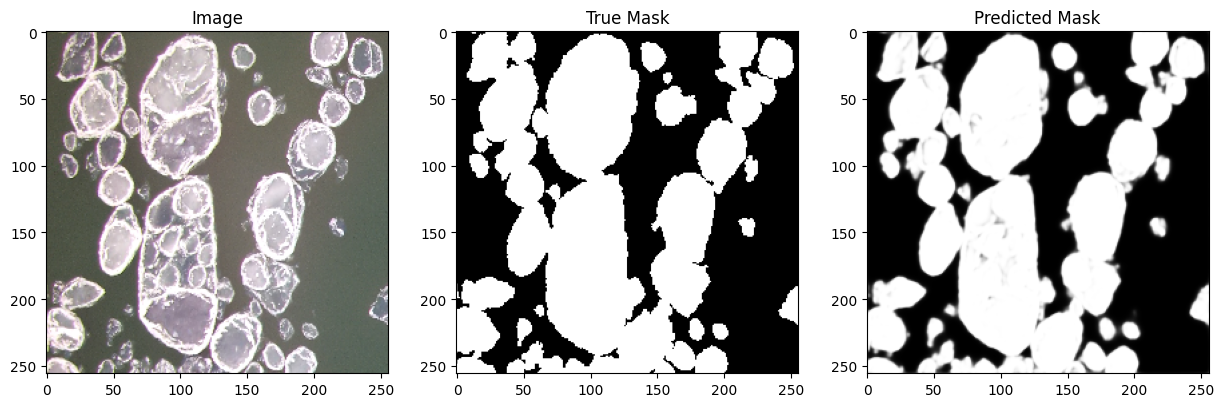

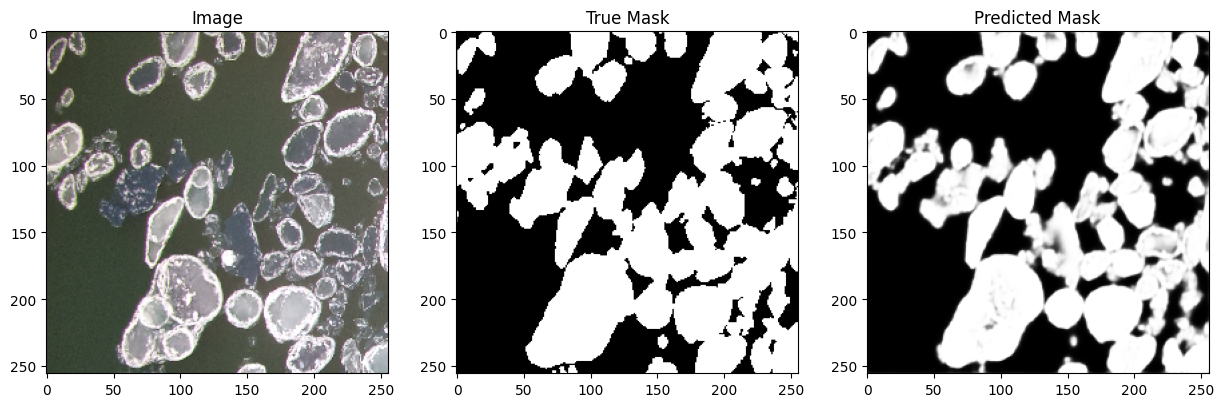

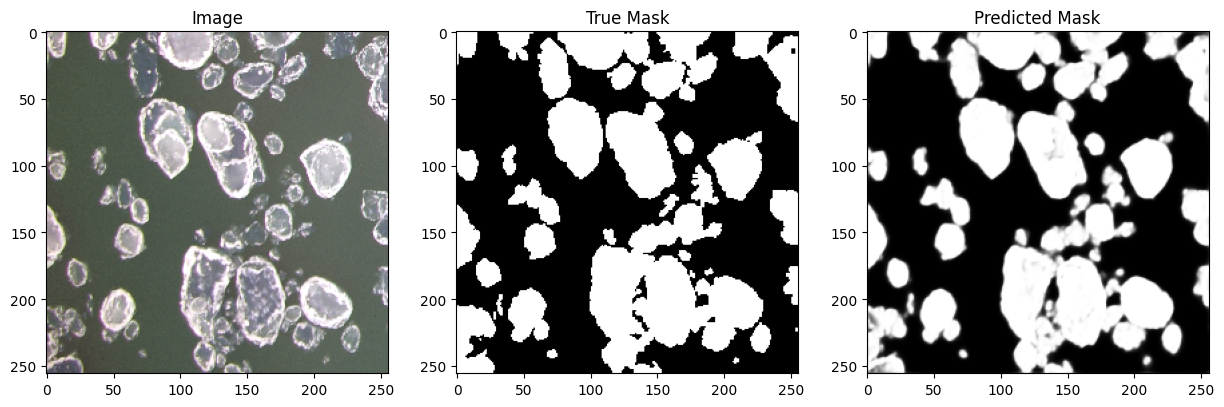

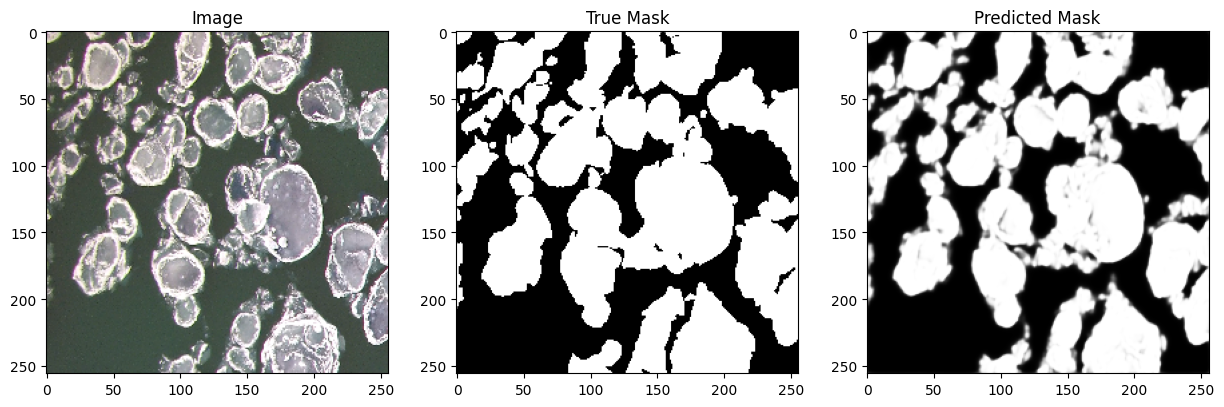

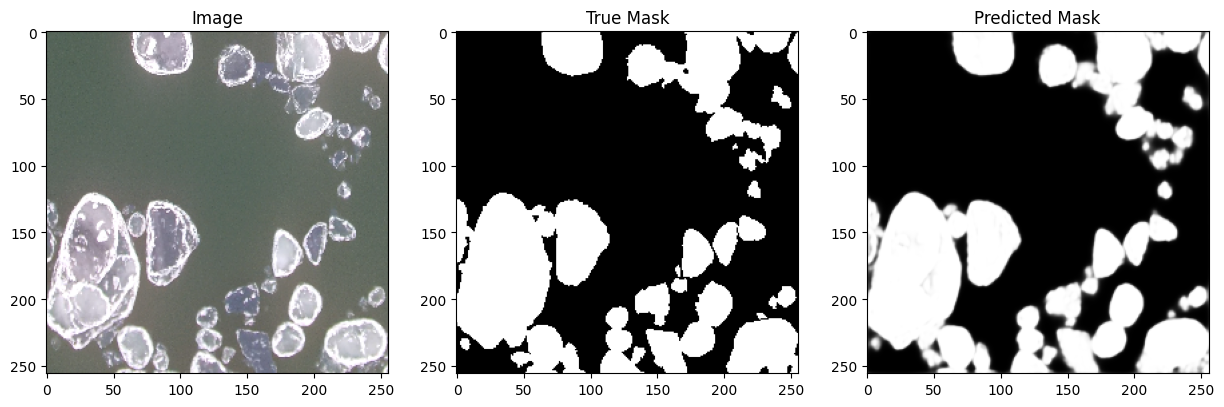

In [4]:
# Predict segmentation masks for validation images
predicted_masks = model.predict(X_val)

# Plotting some results
import matplotlib.pyplot as plt

def plot_results(img, true_mask, pred_mask):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(img.squeeze(), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.show()

# Visualize some results
for i in range(5):  # Plot first 5 results
    plot_results(X_val[i], y_val[i], predicted_masks[i])

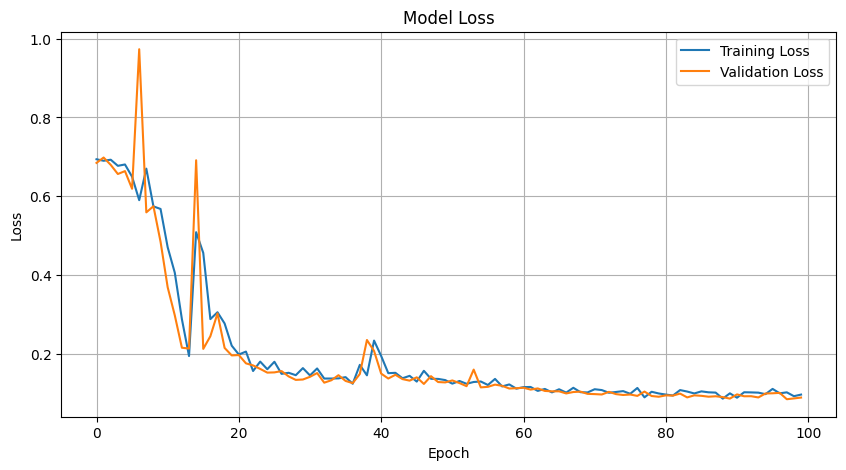

In [5]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()
plt.show()
